We are looking at the problem Max $k$XOR, where each variable is involved in $D+1$ clauses and has no overlapping constraints.

This is code comparing one-local algorithms: Hirvonen's threshold algorithm and Farhi's QAOA at depth 1.

In [1]:
from functools import lru_cache
from matplotlib.ticker import StrMethodFormatter
from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)
from numpy import cos, sin, tan, arctan as atan
from scipy.optimize import minimize
from scipy.special import binom, erf
from sympy import exp, simplify, expand, expand_trig, trigsimp
import matplotlib.pyplot as plt
import numpy as np
import sympy
import time
plt.rc('axes', axisbelow=True)

/tmp/ipykernel_97669/3810261615.py:3: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.
  from mpl_toolkits.axes_grid.inset_locator import (inset_axes, InsetPosition, mark_inset)


In [2]:
print("Starting time:", time.ctime())

Starting time: Tue Sep  7 17:01:11 2021


# QAOA for Max 3XOR

In [3]:
def qaoa_perf_3xor(s, D):
    return s/ ( 1 + 3/(1 - s*s)**D)**0.5

In [4]:
gamma = sympy.Symbol('gamma')
D_symbol = sympy.Symbol('D')
qaoa_perf_3xor(sympy.sin(gamma), D_symbol)

(1 + 3*(1 - sin(gamma)**2)**(-D))**(-0.5)*sin(gamma)

In [5]:
Ds = [5, 10, 20, 50, 100, 500, 1000, 5000, 10000, 50000, 500000]
inps = np.linspace(0, 3, 100000)

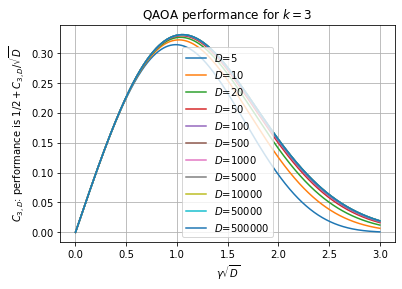

In [6]:
for D in Ds:
    outs = [qaoa_perf_3xor(np.sin(i*D**-0.5), D)*D**0.5 for i in inps]
    plt.plot(inps, outs, label="$D$=" + str(D))
plt.grid()
plt.legend()
plt.title("QAOA performance for $k=3$")
plt.xlabel("$\gamma \sqrt{D}$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.savefig("images/QAOA_max3xor.png",  dpi=300)

We can also look at the derivative of performance with respect to $\gamma$:

In [7]:
qaoa_perf_derivative = sympy.lambdify((gamma, D_symbol), sympy.Derivative(qaoa_perf_3xor(sympy.sin(gamma), D_symbol), gamma, evaluate=True))

5 0.9889298892988929 -7.89382122379223e-06
10 1.019440194401944 -5.557421224877679e-07
20 1.035970359703597 9.036765468040109e-06
50 1.0463804638046381 -6.05624229221835e-06
100 1.049920499204992 -3.116431702476774e-06
500 1.052770527705277 7.448490694839105e-06
1000 1.053130531305313 7.55082733017165e-06
5000 1.053430534305343 -1.179938904916078e-07
10000 1.053460534605346 3.909266844126513e-06
50000 1.053490534905349 3.155058544646039e-06
500000 1.053490534905349 7.4604497740105025e-06


Text(0.5, 1.0, 'first derivative')

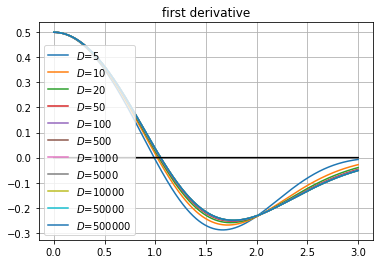

In [8]:
for D in Ds:
    outs = [qaoa_perf_derivative(i*D**-0.5, D) for i in inps]
    plt.plot(inps, outs, label="$D$=" + str(D))
    pt = np.argmin(np.abs(outs))
    print(D, inps[pt], outs[pt])
plt.grid()
plt.plot(inps, [0]*inps, color='black')
plt.legend()
plt.title("first derivative")

Let's check to make sure this works given $\gamma$ and $\beta$. Using the asymptotic values:

In [9]:
def qaoa_perf_2var_3xor(beta, gamma, D):
    p, q = np.cos(2*beta), np.sin(2*beta)
    c, s = np.cos(gamma), np.sin(gamma)
    return 0.5*q*s*(3*p*p*c**D - q*q*c**(3*D))

In [10]:
D = 100
gamma = 1.0535/D**0.5
beta = np.arcsin((1/(np.cos(gamma)**(2*D) + 3))**0.5)/2
print(beta, gamma)
print(qaoa_perf_2var_3xor(beta, gamma, D)*D**0.5)

0.29003649304891665 0.10535000000000001
0.3305431427004284


Text(0.5, 1.0, 'QAOA for Max 3XOR')

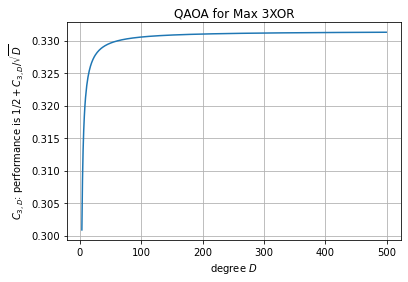

In [11]:
Ds = range(3, 500, 1)
plt.plot(Ds, [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds])
plt.grid()
plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.title("QAOA for Max 3XOR")

Text(0.5, 1.0, 'QAOA for Max 3XOR')

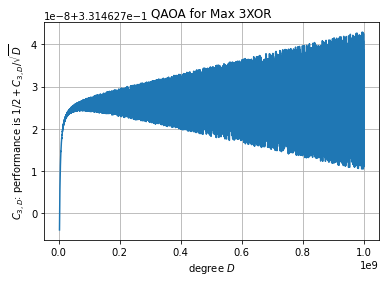

In [12]:
Ds = range(3000000, 1000000000, 100000)
plt.plot(Ds, [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds])
plt.grid()

plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.title("QAOA for Max 3XOR")

What's the asymptotic value of QAOA on Max 3XOR?

In [13]:
def v(k):
    return k / (1 + 3*exp(k*k))**0.5

In [14]:
k = sympy.Symbol('k')
der = sympy.lambdify(k, sympy.Derivative(v(k), k, evaluate=True))

In [15]:
sympy.Derivative(v(k), k, evaluate=True)

-3.0*k**2*(3*exp(k**2) + 1)**(-1.5)*exp(k**2) + (3*exp(k**2) + 1)**(-0.5)

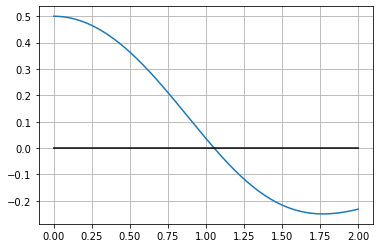

In [16]:
inps = np.linspace(0, 2, 10000000)
plt.plot(inps, der(inps))
plt.plot(inps, [0]*inps, color='black')
plt.grid()

In [17]:
pt = np.argmin(np.abs(der(inps)))
inps[pt], der(inps)[pt]

(1.0535025053502505, 3.2796303450766118e-09)

In [18]:
v(inps[pt])

0.331462726717571

What are the optimal values of QAOA for every degree?

In [19]:
fmaker = lambda D: lambda i: -qaoa_perf_3xor(np.sin(i*D**-0.5), D)*D**0.5

In [20]:
Ds = range(2, 10000)

In [21]:
optimized_vals = [-minimize(fmaker(D), 1).fun for D in Ds]

In [22]:
comparison = [qaoa_perf_2var_3xor(0.29, 1.0535/D**0.5, D)*D**0.5 for D in Ds]
assert np.all(np.array([o-c for o,c in zip(optimized_vals, comparison)]) > 0)

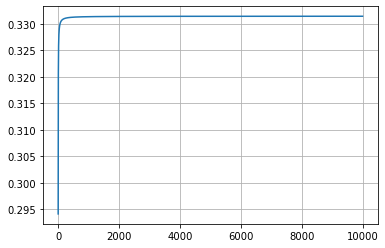

In [23]:
plt.plot(Ds, optimized_vals)
plt.grid()

# The threshold algorithm for Max 3XOR

In [24]:
@lru_cache(maxsize=int(1e7))
def g(D, t):
    return 2**(-D) * sum([binom(D,i) for i in range(0, t+1)])

In [25]:
@lru_cache(maxsize=int(1e7))
def Delta(D, t):
    return 2**(-D)* binom(D, t)

In [26]:
@lru_cache(maxsize=int(1e7))
def general_improvement(D, t, k):
    val_delta = Delta(D, t)
    val_g = g(D, t)
    return 0.25 * ( (1-2*val_g + 2*val_delta)**k - (1 - 2*val_g)**k )

What's the performance at $k=3$?

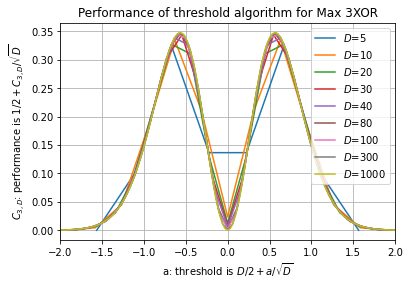

In [27]:
for D in [5, 10, 20, 30, 40, 80, 100, 300, 1000]:
    inps = np.array(list(range(-1, D+2)))
    plt.plot((inps/D - 1/2)*D**0.5, [general_improvement(D, t, 3)*D**0.5 for t in inps], label="$D$=" + str(D))

plt.legend()
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")
plt.xlabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.xlim(-2, 2)
plt.title("Performance of threshold algorithm for Max 3XOR")
plt.grid()

Finding the optimal threshold:

In [28]:
def get_argmax(D, k, negative_only=False):
    if negative_only:
        inps = range(-1, int(D/2))
    else:
        inps = range(-1, D+2)
    return inps[np.argmax([general_improvement(D, t, k) for t in inps])]

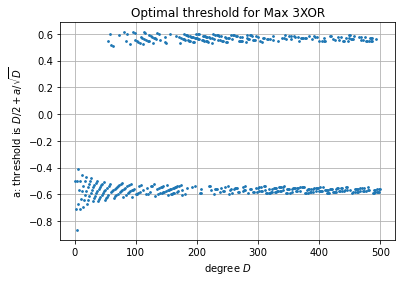

In [29]:
inps = range(1, 500)
plt.scatter(inps, [(get_argmax(D, 3) - D/2)/D**0.5 for D in inps], s=3)
plt.xlabel("degree $D$")
plt.ylabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.title("Optimal threshold for Max 3XOR")
plt.grid()

If we only look at thresholds below $D/2$, we get a clearer pattern:

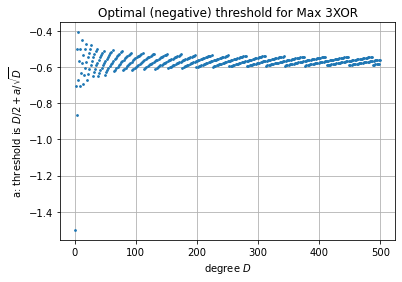

In [30]:
inps = range(1, 500)
plt.scatter(inps, [(get_argmax(D, 3, True) - D/2)/D**0.5 for D in inps], s=3)
plt.xlabel("degree $D$")
plt.ylabel("a: threshold is $D/2 + a/\sqrt{D}$")
plt.title("Optimal (negative) threshold for Max 3XOR")
plt.grid()

# Comparison for Max 3XOR

In [31]:
def get_max(D, k):
    inps = range(-1, D+2)
    return max([general_improvement(D, t, k) for t in inps])

Text(0, 0.5, '$C_{3,D}$: performance is $1/2 + C_{3,D}/\\sqrt{D}$')

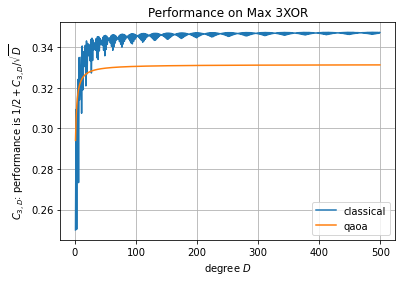

In [32]:
inps = range(1, 500)
plt.plot(inps, [get_max(D, 3)*D**0.5 for D in inps], label='classical')
plt.plot(inps, optimized_vals[:len(inps)], label='qaoa')
plt.legend()
plt.grid()
plt.title("Performance on Max 3XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")

Zooming in at small degree:

Text(0, 0.5, '$C_{3,D}$: performance is $1/2 + C_{3,D}/\\sqrt{D}$')

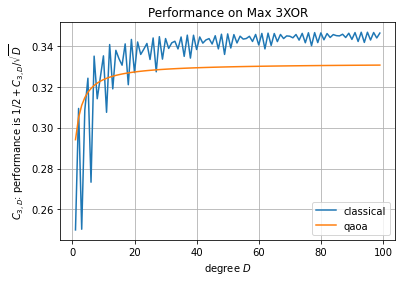

In [33]:
inps = range(1, 100)
plt.plot(inps, [get_max(D, 3)*D**0.5 for D in inps], label='classical')
plt.plot(inps, optimized_vals[:len(inps)], label='qaoa')
plt.legend()
plt.grid()
plt.title("Performance on Max 3XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{3,D}$: performance is $1/2 + C_{3,D}/\sqrt{D}$")

When does QAOA win?

In [34]:
np.array(inps)[[get_max(D, 3)*D**0.5 - o < 0 for D, o in zip(inps, optimized_vals[:len(inps)])]]

array([ 1,  3,  4,  6,  8, 11, 13, 18, 20, 27])

# Threshold algorithm for Max $k$XOR

The performance increases with $k$.

Text(0, 0.5, '$C_{k,D}$: performance is $1/2 + C_{k,D}/\\sqrt{D}$')

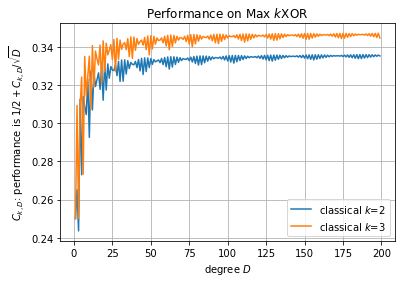

In [35]:
inps = range(1, 200)
for k in range(2, 4):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical $k$=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on Max $k$XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")

Text(0, 0.5, '$C_{k,D}$: performance is $1/2 + C_{k,D}/\\sqrt{D}$')

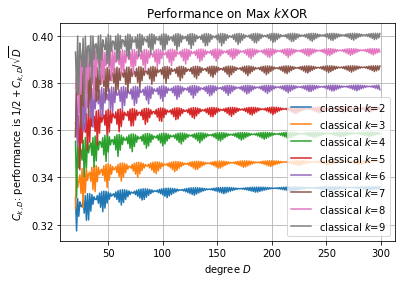

In [36]:
inps = range(20, 300)
for k in range(2, 10):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical $k$=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on Max $k$XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")

Text(0, 0.5, '$C_{k,D}$: performance is $1/2 + C_{k,D}/\\sqrt{D}$')

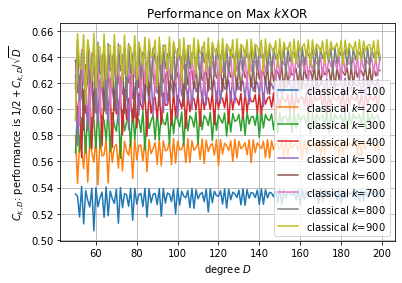

In [37]:
inps = range(50, 200)
for k in range(100, 1000, 100):
    plt.plot(inps, [get_max(D, k)*D**0.5 for D in inps],label="classical $k$=" + str(k))
plt.grid()
plt.legend()
plt.title("Performance on Max $k$XOR")
plt.xlabel("degree $D$")
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")

What about the optimal threshold?

Text(0, 0.5, 'a: threshold is $D/2 + a/\\sqrt{D}$')

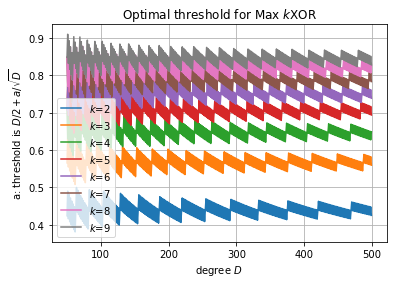

In [38]:
inps = range(50, 500)
for k in range(2,10):
    plt.plot(inps, [abs(get_argmax(D, k) - D/2)/D**0.5 for D in inps], label='$k$=' + str(k))
plt.grid()
plt.legend()
plt.title("Optimal threshold for Max $k$XOR")
plt.xlabel("degree $D$")
plt.ylabel("a: threshold is $D/2 + a/\sqrt{D}$")

### Large degree approximation

alpha (k=2): -0.4384483844838448
improvement*rtD: 0.33648925802613555
alpha (k=3): -0.5661056610566105
improvement*rtD: 0.34753464968074316
alpha (k=4): -0.6461164611646116
improvement*rtD: 0.35948123367974816
alpha (k=5): -0.7040770407704077
improvement*rtD: 0.37007481521513996
alpha (k=6): -0.7493114931149312
improvement*rtD: 0.37934716987803424


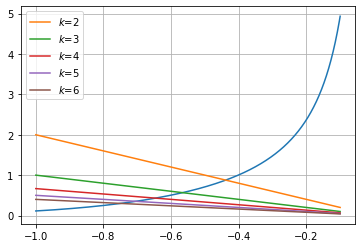

In [39]:
def f(alpha):
    return -erf(2**0.5 * alpha)

def grtD(alpha):
    return (2/np.pi)**0.5 * np.e**(-2*alpha*alpha)

def large_degree_improvement(alpha, k):
    return f(alpha)**k * (k/2) * (-2*alpha)/(k-1)

inps = np.linspace(-1, -0.1, 100000)
plt.plot(inps, [grtD(i)/f(i) for i in inps])
for k in range(2, 7):
    plt.plot(inps, -2*inps/(k-1), label='$k$=' + str(k))
    alpha = inps[[(grtD(i)/f(i)+2*i/(k-1) > 0) for i in inps]][0]
    print('alpha (k=' + str(k) + '):', alpha)
    print('improvement*rtD:', large_degree_improvement(alpha, k))
plt.legend()
plt.grid()

We can use SciPy to find the optimal threshold and value.

In [40]:
fmaker = lambda k: lambda i: abs(grtD(i)/f(i)+2*i/(k-1))

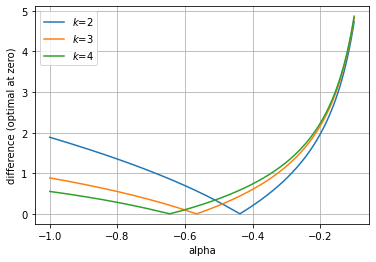

In [41]:
for k in [2,3,4]:
    plt.plot(inps, fmaker(k)(inps), label='$k$=' + str(k))
plt.xlabel("alpha")
plt.ylabel("difference (optimal at zero)")
plt.grid()
plt.legend()

In [42]:
ks = range(2, 200)
best_alphas = [minimize(fmaker(k), -1, method='Nelder-Mead', options={"ftol":1e-10}).x[0] for k in ks]
best_threshold_perf = [large_degree_improvement(a, k) for a,k in zip(best_alphas, ks)]

In [43]:
for i in range(18):
    print("k:", ks[i], "alpha:", best_alphas[i], "perf:", best_threshold_perf[i])

k: 2 alpha: -0.4384504927322263 perf: 0.33649336434608373
k: 3 alpha: -0.566110652685165 perf: 0.34754360662427763
k: 4 alpha: -0.646119719278067 perf: 0.35948708249696404
k: 5 alpha: -0.7040850546211003 perf: 0.37008946845499674
k: 6 alpha: -0.7493118736892935 perf: 0.37934788180340984
k: 7 alpha: -0.7862569719552992 perf: 0.3874867747324553
k: 8 alpha: -0.817399865761399 perf: 0.39471621046350674
k: 9 alpha: -0.8442601535469293 perf: 0.40120335548614106
k: 10 alpha: -0.8678350865840913 perf: 0.4070774997450675
k: 11 alpha: -0.8888135105371475 perf: 0.4124388540093239
k: 12 alpha: -0.9076905906200408 perf: 0.41736591797938943
k: 13 alpha: -0.924833858758211 perf: 0.4219210415038646
k: 14 alpha: -0.9405233614146706 perf: 0.4261543840769254
k: 15 alpha: -0.9549772322177886 perf: 0.43010682728185895
k: 16 alpha: -0.9683685787022114 perf: 0.43381207871486654
k: 17 alpha: -0.9808370001614093 perf: 0.4372982310985033
k: 18 alpha: -0.9924966532737016 perf: 0.4405889197979946
k: 19 alpha: -1.

Text(0.5, 1.0, 'Best asymptotic performance of threshold algorithm for Max $k$XOR')

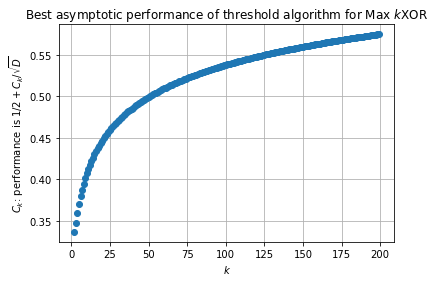

In [44]:
plt.scatter(ks, best_threshold_perf)
plt.grid()
plt.xlabel("$k$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.title("Best asymptotic performance of threshold algorithm for Max $k$XOR")

Comparing the expression with its large-degree asymptotic form:

In [45]:
@lru_cache(maxsize=int(1e7))
def long_range_improvement(D, t, k):
    alpha = (t - D/2)*D**-0.5
    val_delta = (2/np.pi/D)**0.5 * np.e**(-2*alpha*alpha)
    val_g = 0.5 + 0.5*erf(2**0.5 * alpha) + 0.5 * val_delta
    return 0.25 * ( (1-2*val_g + 2*val_delta)**k - (1 - 2*val_g)**k )

Text(0.5, 1.0, 'asymptotic (large-degree) vs generic performance of threshold algorithm; $D$=1000')

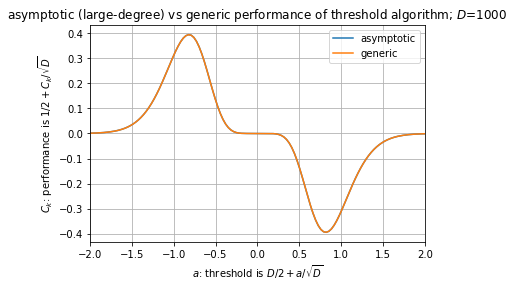

In [46]:
D = 1000
k = 8
inps = np.array(list(range(-1, D+2)))
plt.plot((inps/D - 1/2)*D**0.5, [long_range_improvement(D, t, k)*D**0.5 for t in inps], label='asymptotic')
plt.plot((inps/D - 1/2)*D**0.5, [general_improvement(D, t, k)*D**0.5 for t in inps], label='generic')
plt.xlim(-2, 2)
plt.grid()
plt.xlabel("$a$: threshold is $D/2 + a/\sqrt{D}$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.legend()
plt.title("asymptotic (large-degree) vs generic performance of threshold algorithm; $D$="  +str(D))

# QAOA for Max $k$XOR

We have a relationship from $\gamma$ to $\beta$. So let's plot performance as a single-variable function:

In [47]:
# @lru_cache(maxsize=int(1e7))
def gamma_from_beta(b, k, D):
    return atan( ((tan(2*b)**(-2) + 1)/k/D)**0.5 )

In [48]:
def f(b, k, D):
    p, q = cos(2*b), sin(2*b)
    g = gamma_from_beta(b, k, D)
    c, s = cos(g), sin(g)
    return -0.25*s*1j*( (p + 1j*q*c**D)**k - (p - 1j*q*c**D)**k )

k: 3 D: 2 beta/pi: 0.09113411341134134 gamma: 0.6457133550969802 perf: 0.29410412861806556
k: 3 D: 5 beta/pi: 0.09178417841784199 gamma: 0.4422524799948612 perf: 0.3146569554910147
k: 3 D: 10 beta/pi: 0.09203420342034223 gamma: 0.3223806563933743 perf: 0.32268419004512405
k: 3 D: 20 beta/pi: 0.09215921592159236 gamma: 0.23167755729751552 perf: 0.32697175492210245
k: 3 D: 100 beta/pi: 0.09228422842284248 gamma: 0.10498972786802262 perf: 0.33054742740112547
k: 3 D: 500 beta/pi: 0.09230923092309251 gamma: 0.04707999959190555 perf: 0.33127896219847697
k: 3 D: 1000 beta/pi: 0.09230923092309251 gamma: 0.033302887938561315 perf: 0.33137080088961723
k: 3 D: 10000 beta/pi: 0.09230923092309251 gamma: 0.010534803199471842 perf: 0.3314535299965894
k: 4 D: 2 beta/pi: 0.07350735073507372 gamma: 0.6707077469306936 perf: 0.31273335595182417
k: 4 D: 5 beta/pi: 0.0744824482448247 gamma: 0.460203752247109 perf: 0.33641563218166026
k: 4 D: 10 beta/pi: 0.07485748574857508 gamma: 0.33568475060518954 perf: 0

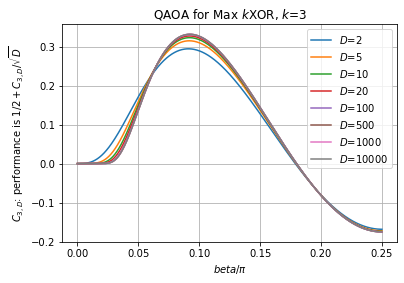

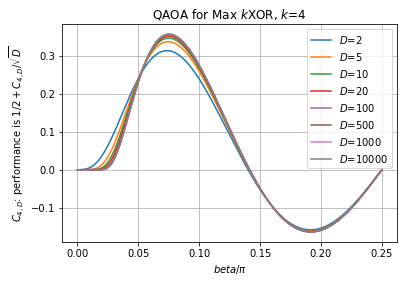

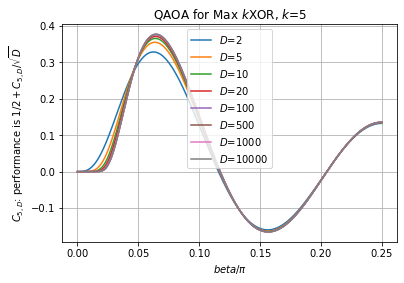

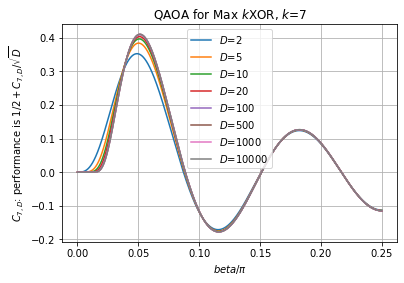

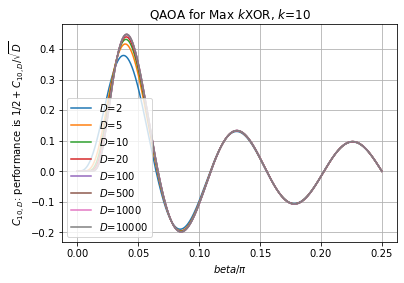

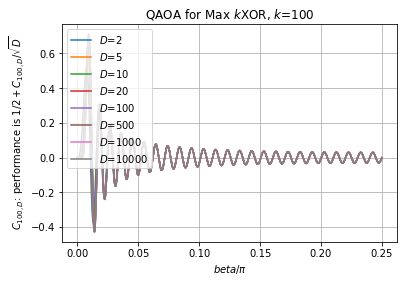

In [49]:
for k in [3, 4, 5, 7, 10, 100]:
    plt.figure()
    Ds = [2, 5, 10, 20, 100, 500, 1000, 10000]
    for D in Ds:
        inps = np.linspace(1e-15, np.pi/4, 10000)
        outs = [complex(f(i, k, D)).real*D**0.5 for i in inps]
        plt.plot(inps/np.pi, outs, label="$D$=" + str(D))
        print('k:', k, "D:", D, 'beta/pi:', inps[np.argmax(outs)]/np.pi, 'gamma:', gamma_from_beta(inps[np.argmax(outs)], k, D), 'perf:', np.max(outs))
    plt.title("QAOA for Max $k$XOR, $k$=" + str(k))
    plt.grid()
    plt.ylabel("$C_{" + str(k) + ",D}$: performance is $1/2 + C_{" + str(k) + ",D}/\sqrt{D}$")
    plt.xlabel("$ beta / \pi$")
    plt.legend()

Find the maximum performance of QAOA for any k and D:

In [50]:
fmaker = lambda k, D: lambda i: -complex(f(i, k, D)).real*D**0.5

In [51]:
def get_qaoa_max(k,D):
    # do pass to find approximate optimum
    inps = np.linspace(1e-15, np.pi/4, 100)
    outs = [complex(f(i, k, D)).real*D**0.5 for i in inps]
    return -minimize(fmaker(k, D), inps[np.argmax(outs)]).fun

CPU times: user 9.06 s, sys: 39.6 ms, total: 9.1 s
Wall time: 9.16 s


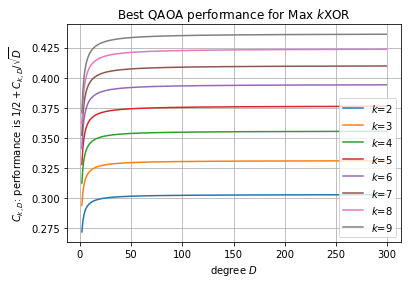

In [52]:
%%time
for k in range(2, 10):
    Ds = range(2, 300)
    qaoa_kxor = [get_qaoa_max(k,D) for D in Ds]
    plt.plot(Ds, qaoa_kxor, label="$k$=" + str(k))
plt.grid()
plt.xlabel('degree $D$')
plt.legend()
plt.ylabel("$C_{k,D}$: performance is $1/2 + C_{k,D}/\sqrt{D}$")
plt.title("Best QAOA performance for Max $k$XOR")
plt.savefig('images/qaoa_best_maxkxor.png',  dpi=300)

### Limiting behavior for QAOA on Max $k$XOR

In [53]:
def qaoa_asymptotic_kxor(k,t):
    if t*t*k < 1:
        return 0
    term_1 = (t*t*k - 1)**0.5 + 1j*np.e**(-t*t/2)
    term_2 = (t*t*k - 1)**0.5 - 1j*np.e**(-t*t/2)
    return -0.25*1j * t**(1-k) * k**(-k/2) * (term_1**k - term_2**k)

k= 2 Max: 0.30326532976533727 at t= 1.000010000100001 beta= 0.3926940817237238
k= 3 Max: 0.33146272666069077 at t= 1.053510535105351 beta= 0.2900007252938392
k= 4 Max: 0.3559421057897224 at t= 1.097790977909779 beta= 0.2364444875259528
k= 5 Max: 0.3767105761875506 at t= 1.134771347713477 beta= 0.20254429534400661
k= 6 Max: 0.3945945274726129 at t= 1.1663716637166373 beta= 0.1787938843543141
k= 7 Max: 0.41025178270098717 at t= 1.1939319393193932 beta= 0.16105629649069836
k= 8 Max: 0.42415677803753304 at t= 1.2183321833218332 beta= 0.14721507819709934
k= 9 Max: 0.436652898412887 at t= 1.2402124021240213 beta= 0.1360585132329121
k= 10 Max: 0.4479939244835788 at t= 1.2600526005260053 beta= 0.12683796844261103
k= 11 Max: 0.45837176828801823 at t= 1.2781727817278172 beta= 0.1190684308018922
k= 12 Max: 0.46793469585178904 at t= 1.2948529485294853 beta= 0.1124149146297139
k= 13 Max: 0.4767994633283053 at t= 1.3103131031310313 beta= 0.10664016752303325
k= 14 Max: 0.48505957497866997 at t= 1.324

Text(0, 0.5, '$C_{k}$: performance is $1/2 + C_{k}/\\sqrt{D}$')

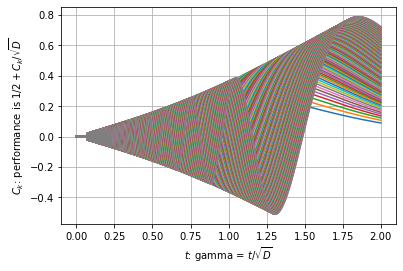

In [54]:
qaoa_asymptotic_maxes = []
for k in range(2, 200):
    inps = np.linspace(0, 2, 100000)
    outs = [qaoa_asymptotic_kxor(k,i).real for i in inps]
    plt.plot(inps, outs, label="$k$=" + str(k))
    if k < 20 or k % 5 == 0:
        t = inps[np.nanargmax(outs)]
        print("k=", str(k), "Max:", np.nanmax(outs), "at t=", t, 'beta=', np.arcsin(1/t/k**0.5)/2)
    qaoa_asymptotic_maxes.append(np.nanmax(outs))
plt.grid()
plt.xlabel("$t$: gamma = $t/\sqrt{D}$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
# plt.legend()

# Comparison for Max $k$XOR

CPU times: user 9.74 s, sys: 64 ms, total: 9.81 s
Wall time: 9.8 s


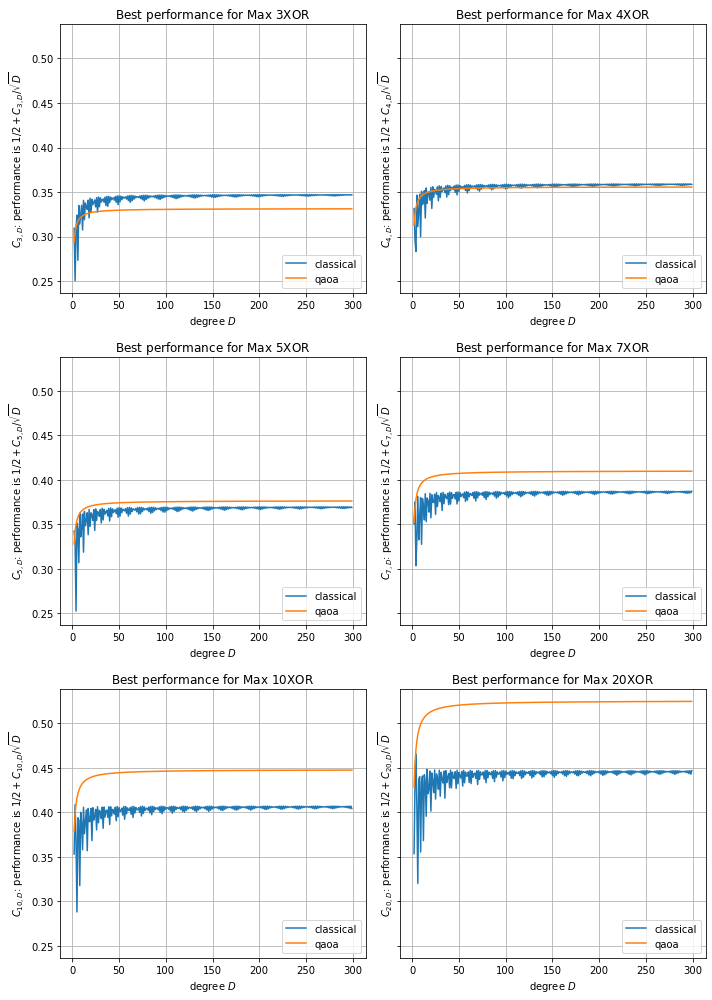

In [55]:
%%time
fig, axs = plt.subplots(3, 2, sharey=True, figsize=(10, 14))
axs = axs.reshape(-1,)
ks = [3, 4, 5, 7, 10, 20]
for i in range(len(ks)):
    ax = axs[i]
    k = ks[i]
    Ds = range(2,300)
    ax.plot(Ds, [get_max(D, k)*D**0.5 for D in Ds], label='classical')
    ax.plot(Ds, [get_qaoa_max(k,D) for D in Ds], label='qaoa')
    ax.grid()
    ax.set_xlabel('degree $D$')
    ax.legend(loc='lower right')
    ax.set_ylabel("$C_{" + str(k) + ",D}$: performance is $1/2 + C_{" + str(k) + ",D}/\sqrt{D}$")
    ax.set_title("Best performance for Max $" + str(k) + "$XOR")
fig.tight_layout()
plt.savefig('images/comparison.png',  dpi=300)

So for $k > 4$, the QAOA does better than the threshold algorithm.

This is true even in the large-degree limit.

In [56]:
max([q for q in qaoa_asymptotic_maxes if q != np.inf])

0.7882407077057314

/tmp/ipykernel_97669/2547371314.py:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor='w', fontsize=9)


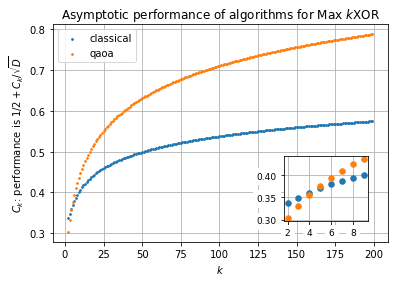

In [57]:
fig, ax1 = plt.subplots()
ks = range(2, 200)
ax1.scatter(ks[:len(best_threshold_perf)], best_threshold_perf, label='classical', s=3)
ax1.scatter(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa', s=3)
ax1.grid()
ax1.set_xlabel("$k$")
ax1.set_ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
ax1.legend(loc=0)
ax1.set_title("Asymptotic performance of algorithms for Max $k$XOR")

# Following https://scipython.com/blog/inset-plots-in-matplotlib/
ax2 = plt.axes([0,0,1,1])
ip = InsetPosition(ax1, [0.69,0.095,0.25,0.3])
ax2.set_axes_locator(ip)
max_k_vals_inset = 8
ax2.grid()
ax2.scatter(ks[:max_k_vals_inset], best_threshold_perf[:max_k_vals_inset], s=30, label='classical')
ax2.scatter(ks[:max_k_vals_inset], qaoa_asymptotic_maxes[:max_k_vals_inset],  s=30, label='qaoa')
ax2.set_xticks(np.arange(2, max_k_vals_inset+2, 2))
ax2.set_xticklabels(ax2.get_xticks(), backgroundcolor='w', fontsize=9)
ax2.set_yticklabels(ax2.get_yticks(), backgroundcolor='w', fontsize=9)
ax2.yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}')) # 2 decimal places

plt.savefig('images/asymptotic_comparison.png',  dpi=300)
plt.show()

In [58]:
def logfit(x, y, deg=1):
    logx = np.log(x)
    logy = np.log(y)
    return np.polyfit(logx,logy,deg=deg)

# poly = np.poly1d(coeffs)
# yfit = lambda x: np.exp(poly(np.log(x)))
# plt.loglog(inps, yfit(inps))
# plt.loglog(inps, dataset)

In [59]:
dataset = qaoa_asymptotic_maxes
inps = ks[:len(dataset)]

qaoa_coeffs = logfit(inps, dataset, deg=1)
print(qaoa_coeffs)

dataset = best_threshold_perf
inps = ks[:len(dataset)]

threshold_coeffs = logfit(inps, dataset, deg=1)
print(threshold_coeffs)

[ 0.1917382  -1.23055679]
[ 0.11544326 -1.15496742]


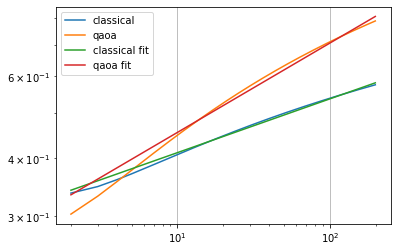

In [60]:
plt.loglog(ks, best_threshold_perf, label='classical')
plt.loglog(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa')
plt.loglog(ks, [(np.e**threshold_coeffs[1])*k**threshold_coeffs[0] for k in ks], label='classical fit')
plt.loglog(ks, [(np.e**qaoa_coeffs[1])*k**qaoa_coeffs[0] for k in ks], label='qaoa fit')
plt.legend()
plt.grid()

This suggests that QAOA's performance scales as $k^{0.2}$ and the threshold algorithm's performance scales as $k^{0.1}$.

# Comparison with the Parisi constant (upper bound at large degree)

kXOR:
p: 2 1.883249725558715
p: 3 1.9927455248969128
p: 4 2.021981615495777
p: 5 2.0321685235139197
p: 6 2.0362008561657916
p: 7 2.0379159132080638
p: 8 2.0386779530175447
p: 9 2.0390260819660497
p: 10 2.03918804589269
p: 11 2.0392643310453185
p: 12 2.039300570243631
p: 13 2.0393178919308443
p: 14 2.0393262094756714
p: 15 2.039330217612541
p: 16 2.0393321545959395
p: 17 2.039333092871928
p: 18 2.0393335482804424
p: 19 2.039333769702445
p: 20 2.0393338775223278
p: 21 2.039333930095328
p: 22 2.0393339557610126
p: 23 2.039333968304522
p: 24 2.039333974440982
p: 25 2.039333977445782
p: 26 2.0393339789183393
p: 27 2.039333979640574
p: 28 2.0393339799950354
p: 29 2.039333980169129
p: 30 2.0393339802546784
p: 31 2.0393339802967425
p: 32 2.039333980317405
p: 33 2.0393339803275836
p: 34 2.039333980332607
CPU times: user 1min 14s, sys: 35.4 ms, total: 1min 14s
Wall time: 1min 14s


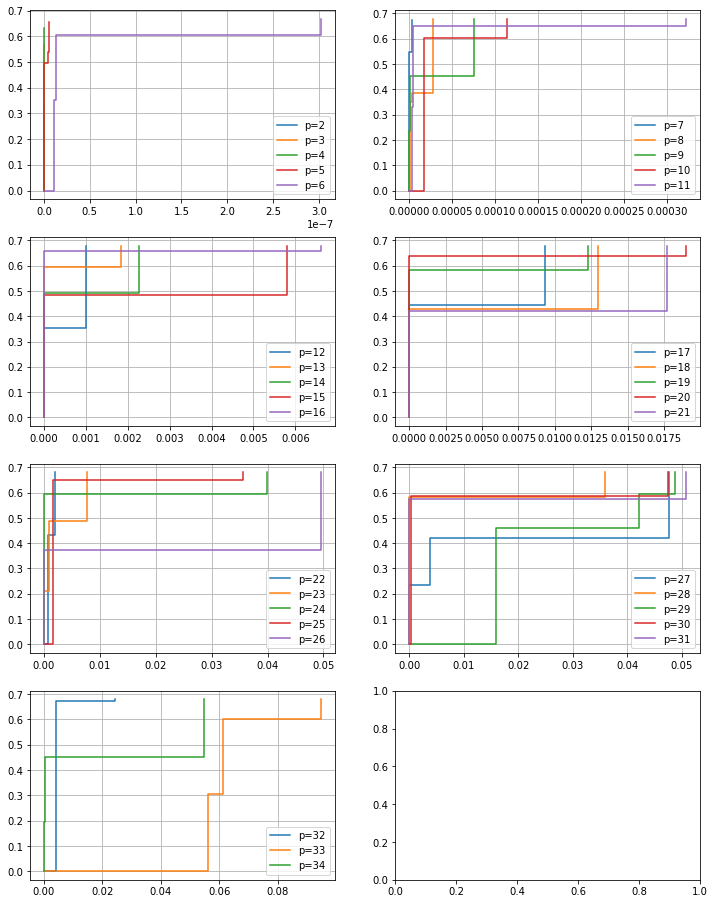

2 1.0872947360026128
3 1.1505121652256547
4 1.167391630002961
5 1.1732730440894459
6 1.1756011124314663
7 1.1765913010764975
8 1.1770312649656347
9 1.1772322573077667
10 1.1773257672244113
11 1.1773698104778167
12 1.1773907331887175
13 1.177400733869493
14 1.1774055360062379
15 1.1774078501051386
16 1.1774089684230251
17 1.1774095101369197
18 1.177409773067148
19 1.1774099009052008
20 1.1774099631550392
21 1.177409993508075
22 1.177410008326165
23 1.1774100155681635
24 1.1774100191110504
25 1.1774100208458724
26 1.1774100216960537
27 1.1774100221130361
28 1.1774100223176844
29 1.1774100224181976
30 1.1774100224675894
31 1.177410022491875
32 1.1774100225038047
33 1.1774100225096813
34 1.1774100225125816
1.1774100225154747


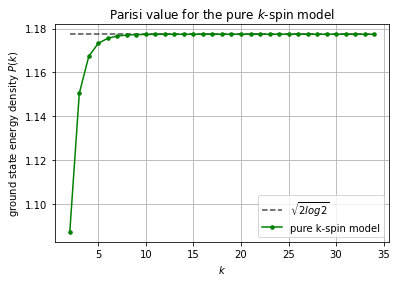

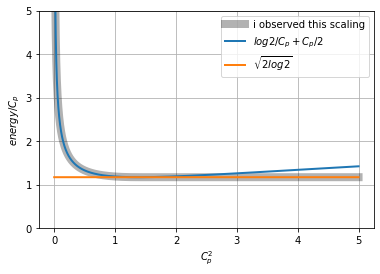

my result, p: 2 e_p: 0.7688334809758846
my result, p: 3 e_p: 0.8135349538686781
2 0.7688334809758846
3 0.9963727624484563
4 1.167391630002961
5 1.3117591413760545
6 1.439811433252685
7 1.5564839887051678
8 1.6645735782515607
9 1.76584838596165
10 1.8615154862171768
11 1.9524469504233828
12 2.0393005702436304
13 2.1225893588676934
14 2.2027240605131357
15 2.2800404975755404
16 2.3548179368460502
17 2.4272918874506337
18 2.4976633043132828
19 2.5661053865850048
20 2.6327687150001906
21 2.697785209624109
22 2.7612712294134396
23 2.823330034262959
24 2.884053764862663
25 2.943525052114681
26 3.001818338063941
27 3.059000969460861
28 3.1151341102076024
29 3.170273508146962
30 3.224470143690816
31 3.2777707818345783
32 3.3302184445977834
33 3.381852817484307
34 3.432710600889793
kSAT:
p: 3 2.226113963695299
p: 4 3.7566602599662486
p: 5 5.8483538775559305
p: 6 8.734932297735998
p: 7 12.748884871048668


/tmp/ipykernel_97669/19398768.py:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 8 18.3626959918709


/tmp/ipykernel_97669/19398768.py:9: RuntimeWarning: overflow encountered in power
  Expectation(lambda x, z: np.e**(ms[l]*offset(x,z)))(v)


p: 9 20.018110210927944
CPU times: user 1min 39s, sys: 7.71 ms, total: 1min 39s
Wall time: 1min 39s


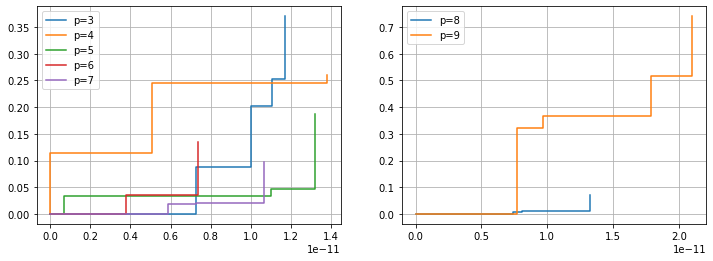

3 2.226113963695299
4 3.7566602599662486
5 5.8483538775559305
6 8.734932297735998
7 12.748884871048668
8 18.3626959918709
9 20.018110210927944
3 0.27826424546191236
4 0.23479126624789054
5 0.18276105867362283
6 0.13648331715212497
7 0.09960066305506772
8 0.0717292812182457
9 0.03909787150571864
CPU times: user 2min 55s, sys: 115 ms, total: 2min 55s
Wall time: 2min 56s


In [61]:
%%time
%run parisi.ipynb

In [62]:
parisi_clean_data = np.array([[p, x * p**0.5 / 2] for p,x in zip(ps, outs_scaled)])

In [63]:
parisi_estimate = lambda x: (x*np.log(2)/2)**0.5

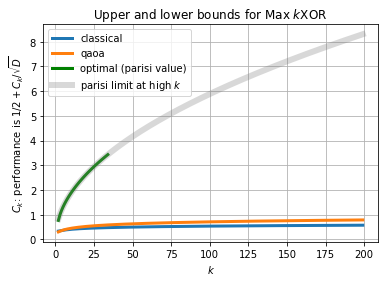

In [64]:
size = len(parisi_clean_data)
ks = np.array(list(range(2, 200)))
assert np.allclose(ks[:size], parisi_clean_data[:, 0])

plt.plot(ks[:len(best_threshold_perf)], best_threshold_perf, label='classical', linewidth=3)
plt.plot(ks[:len(qaoa_asymptotic_maxes)], qaoa_asymptotic_maxes, label='qaoa', linewidth=3)
plt.plot(parisi_clean_data[:, 0], parisi_clean_data[:,1], label='optimal (parisi value)', color='green', linewidth=3)
plt.plot(ks, parisi_estimate(ks), label='parisi limit at high $k$', color='gray', alpha=0.3, linewidth=6)

plt.grid()
plt.xlabel("$k$")
plt.ylabel("$C_{k}$: performance is $1/2 + C_{k}/\sqrt{D}$")
plt.legend()
plt.title("Upper and lower bounds for Max $k$XOR")
plt.savefig('images/parisi_comparison.png',  dpi=300)

In [65]:
print("Ending time:", time.ctime())

Ending time: Tue Sep  7 17:09:02 2021
